# Natural Language Processing for APSMarch2021 titles and abstracts

we'll create a search engine for the APS DPOLY titles using contextual embeddings (ELMo)


This notebook is a modified version of that described at:

https://towardsdatascience.com/elmo-contextual-language-embedding-335de2268604

https://github.com/jonathankwhitmer/DPOLY-2020-SC (DPOLY workshop APSMarch2020)

# Imports

Load all the various libraries necessary to make the notebook run

In [ ]:
##library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
import os
#import numpy as np
#import pandas as pd
import pickle

# Use tensorflow version 2. This is for Colab.
%tensorflow_version 2.x

import tensorflow as tf
print (tf.__version__)
import tensorflow_hub as hub
from sklearn import preprocessing

from IPython.display import HTML
import logging
logging.getLogger('tensorflow').disabled = True #OPTIONAL - to disable outputs from Tensorflow

2.4.1


## Get the data 

We need to get a list of the abstracts, as well as the embeddings since the embeddings will take too long to train over the entire set.

In [ ]:
# get the abstract data of APSMarch2021
!wget https://github.com/shijiale0609/NLP_APS_abstract/raw/main/APSMarch2021.pkl
!wget https://github.com/shijiale0609/NLP_APS_abstract/raw/main/titleembeddings.pkl

--2021-02-15 16:19:40--  https://github.com/shijiale0609/NLP_APS_abstract/raw/main/APSMarch2021.pkl
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/shijiale0609/NLP_APS_abstract/main/APSMarch2021.pkl [following]
--2021-02-15 16:19:40--  https://raw.githubusercontent.com/shijiale0609/NLP_APS_abstract/main/APSMarch2021.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15725598 (15M) [application/octet-stream]
Saving to: ‘APSMarch2021.pkl’

APSMarch2021.pkl    100%[===================>]  15.00M  70.7MB/s    in 0.2s    

2021-02-15 16:19:40 (70.7 MB/s) - ‘APSMarch2021.pkl’ saved [15725598/1572

In [ ]:
# read the csv
df = pd.read_pickle('APSMarch2021.pkl')

In [ ]:
## get the titles for all the abstract. 
title_list = df['Title'].tolist()
print (len(title_list))
print (df['Title'][1999])
print (df['Abstract'][1999])
print (df['url'][1999])


10094
Freestanding Sr2IrO4 nanomembranes: structural and optical properties
We report the structural and optical properties of nanoscale freestanding Sr2IrO4 thin film fabricated using a sacrificial water-soluble Sr3Al2O6 layer. The coherent lattice structure, phonon modes, two-magnon Raman scattering, and optical absorption spectra of the freestanding Sr2IrO4 nanomembrane are analogous to those of the layered iridate epitaxial thin-films and single crystals. Remarkably, the 3-unit-cell-thick SrIrO3 interfacial layers alleviate the formation of antiphase boundaries at the Sr2IrO4/Sr3Al2O6 interface, resulting in structurally-robust freestanding thin-film. Our experimental results show that this freestanding thin-film approach of layered oxides can provide techniques for tuning or realizing unprecedented states beyond conventional thin film methods, suggesting a pathway in achieving two-dimensional layered oxides electronics.
https://meetings.aps.org/Meeting/MAR21/Session/C54.1


## Create sentence embeddings

We'll do this for only twenty random abstracts in the interest of time, but this can be easily modified to create the embeddings for the entire set.

First, we get the model for the embeddings.

In [ ]:
url = "https://tfhub.dev/google/elmo/3" # get the model for the embeddings
embed = hub.load(url)

Actually perform the embedding
-------
We train 500 titles since the limit of the memory

In [ ]:
%%time

# Here we use the default embedding, which is a fixed mean-pooling of all contextualized word representations or in other words, sentence embedding instead of word embedding (see https://tfhub.dev/google/elmo/2)
embeddings = embed.signatures['default'](tf.convert_to_tensor(title_list[0:500]))['default']



CPU times: user 1.51 s, sys: 755 ms, total: 2.26 s
Wall time: 7.37 s


In [ ]:
embeddings

<tf.Tensor: shape=(500, 1024), dtype=float32, numpy=
array([[-0.12477203, -0.05935965,  0.45035282, ...,  0.06580848,
         0.09966489, -0.2717036 ],
       [-0.24195193, -0.23942824, -0.08454262, ..., -0.06641274,
         0.11909106, -0.37264633],
       [-0.13392486,  0.18585329, -0.04809775, ...,  0.20629711,
         0.47646847, -0.03167387],
       ...,
       [-0.04131991,  0.12521783,  0.24550864, ...,  0.03045699,
         0.33972222, -0.18134496],
       [ 0.21943586,  0.26187283,  0.25986555, ..., -0.19191241,
         0.21547341, -0.05831806],
       [-0.1449011 , -0.38635668, -0.06909034, ..., -0.05145966,
         0.10960076,  0.12563978]], dtype=float32)>

If you want to train all the remaining titles, run the cell below. 

In [ ]:
#for i in range(1,21):
#  print (i)
#  left = 500*i
#  right = 500*(i+1)
#  if right >= len(title_list):
#    right = len(title_list)
#  # Here we use the default embedding, which is a fixed mean-pooling of all contextualized word representations or in other words, sentence embedding instead of word embedding (see https://tfhub.dev/google/elmo/2)
#  embeddings_new = embed.signatures['default'](tf.convert_to_tensor(title_list[left:right]))['default']
#  embeddings = tf.concat([embeddings, embeddings_new], 0)

#pickle.dump(embeddings, open("titleembeddings.pkl", "wb"))

## PCA classification for the embeddings 

[0.20240788 0.04797787]
[8.73284378 2.06999472]


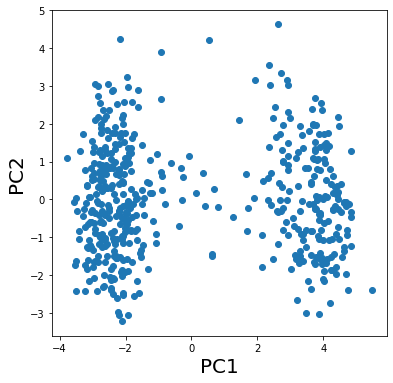

In [ ]:
pca = PCA(n_components=2, random_state=20)
result = pca.fit_transform(embeddings)#
print (pca.explained_variance_ratio_)
print (pca.explained_variance_)

PC1=[i[0] for i in result]
PC2=[i[1] for i in result]
import matplotlib.pyplot as plt
plt.figure(figsize=(6,6))
plt.scatter(list(PC1), list(PC2))
plt.xlabel('PC1', size = 20)
plt.ylabel('PC2', size = 20)
plt.show()

[0.20240788 0.04797787 0.03519295]
[8.73284378 2.06999473 1.51839202]


/usr/local/lib/python3.6/dist-packages/matplotlib/collections.py:885: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


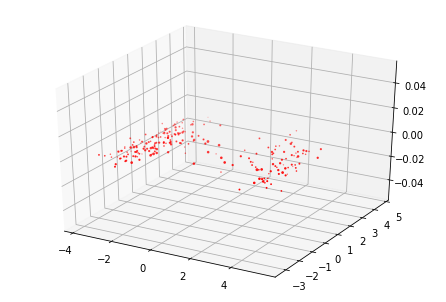

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
from sklearn.decomposition import PCA
pca = PCA(n_components=3, random_state=20)
result = pca.fit_transform(embeddings)#
print (pca.explained_variance_ratio_)
print (pca.explained_variance_)

PC1=[i[0] for i in result]
PC2=[i[1] for i in result]
PC3=[i[2] for i in result]

fig = plt.figure()
#ax = Axes3D(fig, rect=[0, 0, 1, 1], elev=30, azim=20)
ax = Axes3D(fig)

plt.scatter(PC1, PC2, PC3,  c='r',marker='o')

plt.show()

## Upload the data for the entire set of abstracts

In [ ]:
fullembeddings = pickle.load(open('titleembeddings.pkl','rb'))

In [ ]:
## Get the word embedding for the search string
search_string = "free energy calculation" 
results_returned = 5

from sklearn.metrics.pairwise import cosine_similarity

# perform sentence embedding on the search string
search_vect = embed.signatures['default'](tf.convert_to_tensor([search_string]))['default']

# find the cosine similarity for every title
# you can learn more about distance metrics here: https://towardsdatascience.com/importance-of-distance-metrics-in-machine-learning-modelling-e51395ffe60d
#res = cosine_similarity(search_vect,fullembeddings).flatten()
res = cosine_similarity(search_vect,fullembeddings).flatten()


res1 = res.ravel().argsort()[-results_returned:]
res1 = res1.tolist()
res1.reverse()


In [ ]:
print ("Top" +str(results_returned), "titles for '{}':\n\n".format(search_string))
#print (res[title_list.index("Free energy landscapes and transition rates of dynamic properties of Au4 neutral and charged clusters at finite temperature")])
for i in range(0, len(res1)):
    print(i+1, "cosine similarity = ", res[res1[i]], '\n', "Title:",title_list[res1[i]],'\n', "url:", df['url'][res1[i]])
    print ('\n')

Top5 titles for 'free energy calculation':


1 cosine similarity =  0.69891816 
 Title: pgm: A Python package for free energy calculation 
 url: https://meetings.aps.org/Meeting/MAR21/Session/P19.3


2 cosine similarity =  0.6366174 
 Title: Direct calculation of kinetics from free energy surfaces 
 url: https://meetings.aps.org/Meeting/MAR21/Session/P25.3


3 cosine similarity =  0.5942129 
 Title: Free energy calculations on the stability of polymer-grafted nanoparticle superlattices 
 url: https://meetings.aps.org/Meeting/MAR21/Session/P16.10


4 cosine similarity =  0.573092 
 Title: A top-down and bottom-up strategy to generate free volume for membrane-based gas separations 
 url: https://meetings.aps.org/Meeting/MAR21/Session/B04.6


5 cosine similarity =  0.5727252 
 Title: Energy conservation equation for one-component pseudopotential lattice Boltzmann method 
 url: https://meetings.aps.org/Meeting/MAR21/Session/J25.6




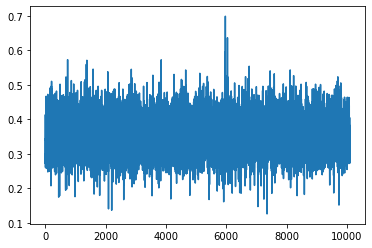

In [ ]:
plt.plot(res)